# Index

1. [Loading Data](#data)
    1. [Boston House Prices Data Summary](#boston)
2. [EDA](#eda)
    1. [Initial analysis](#ia)
    2. [Possible Maximum Quantization Error](#mqe)
3. [Ordinary Least Squares](#ols)
    1. [Model 1: OLS on RM](#rm)
    2. [Model 2: Ridge on Log of LSTAT Column](#lstat)
4. [Single Column Regression Compairison](#pr)
    1. [Model 3: 5th Order Polynomial Regression on LSTAT](#rls)
5. [Multi Column Regressions](#mcr)
    1. [Model 4: Ridge on all columns](#all)

# 1. Loading Data
<a id = "data"></a>

In [1]:
#Standard Libraries
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()

X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

#### <center> Boston house prices dataset</center> <a id = "boston"></a> 
|Column| Description |
| --- | --- |
|<strong>CRIM</strong>|per capita crime rate by town <br>
|<strong>ZN</strong>|proportion of residential land zoned for lots over 25,000 sq.ft.<br>
|<strong>INDUS</strong>|proportion of non-retail business acres per town<br>
|<strong>CHAS</strong>|Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)<br>
|<strong>NOX</strong>|nitric oxides concentration (parts per 10 million)<br>
|<strong>RM</strong>|average number of rooms per dwelling<br>
|<strong>AGE</strong>|proportion of owner-occupied units built prior to 1940<br>
|<strong>DIS</strong>|weighted distances to five Boston employment centres<br>
|<strong>RAD</strong>|index of accessibility to radial highways<br>
|<strong>TAX</strong>|full-value property-tax rate per \$10,000<br>
|<strong>PTRATIO</strong>|pupil-teacher ratio by town<br>
|<strong>B</strong>|1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town<br>
|<strong>LSTAT</strong>|\% lower status of the population<br>
|<strong>MEDV</strong>|Median value of owner-occupied homes in \$1000's<br>

# 2. EDA <a id = "eda"></a>

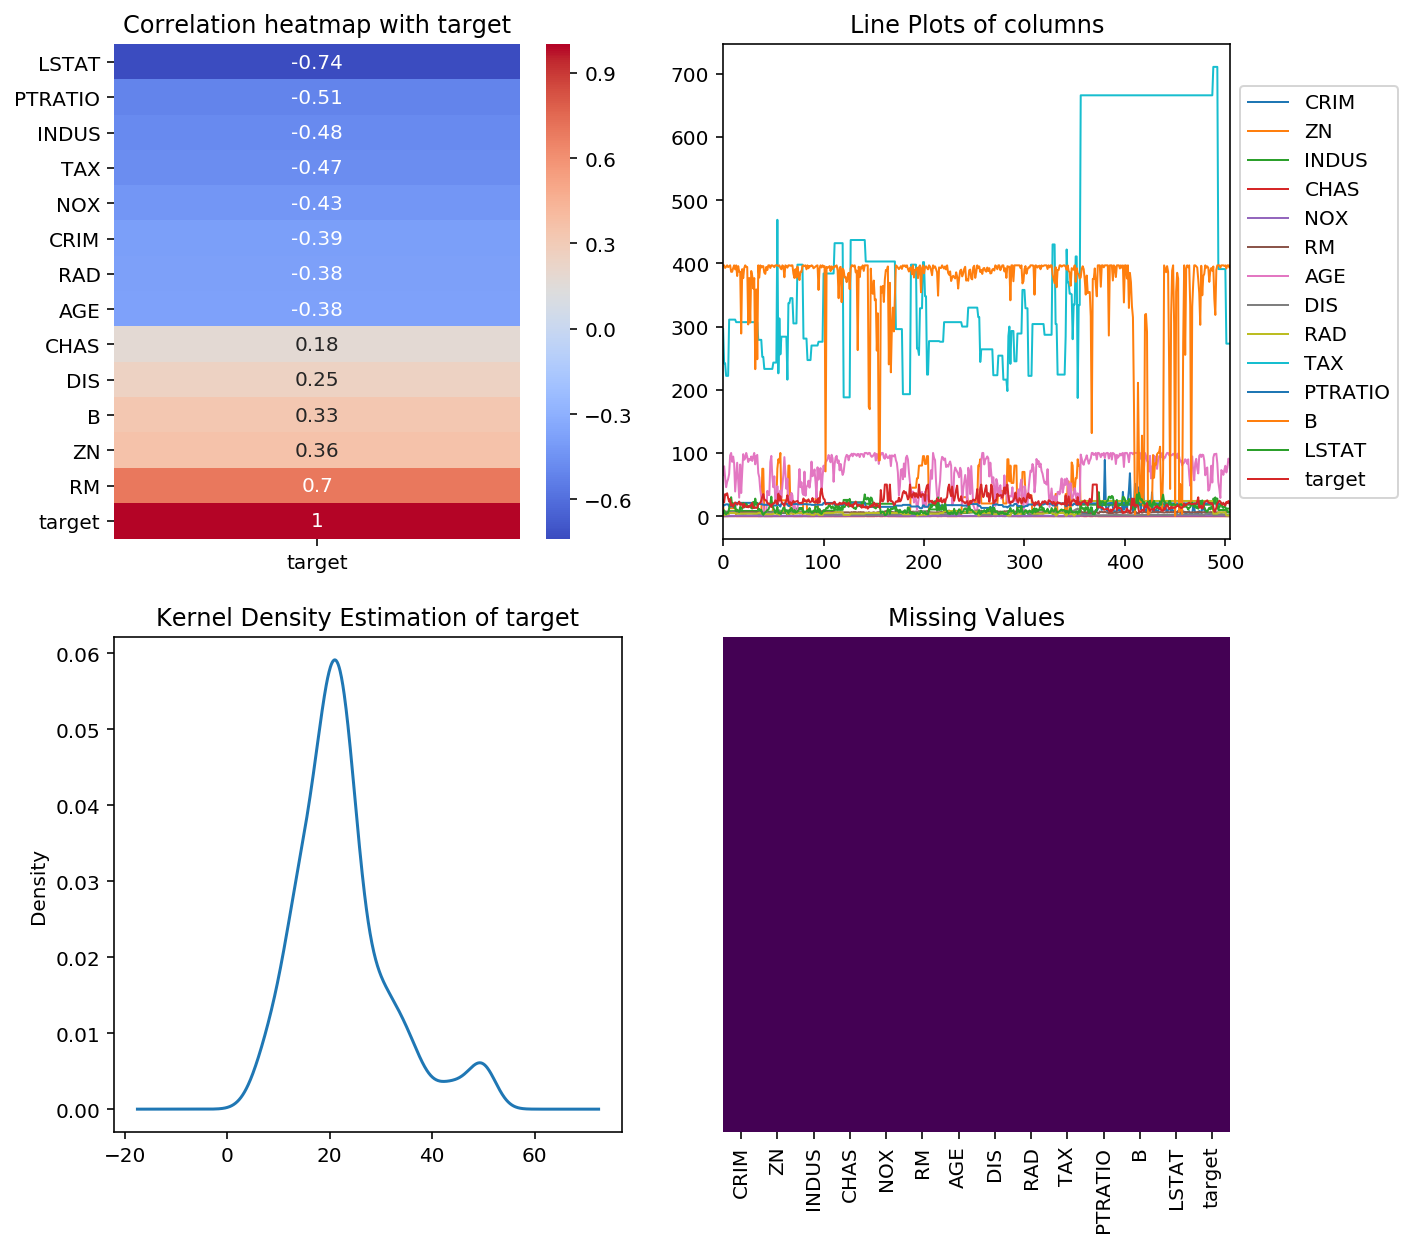

In [3]:
df = X.copy()
df["target"] = y

figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax[0,0].set_title("Correlation heatmap with target");
sns.heatmap(df.corr()[['target']].sort_values("target"), annot=True, cmap='coolwarm', ax = ax[0,0]);

ax[0,1].set_title("Line Plots of columns");
df.plot(lw = 1, ax = ax[0,1]);
ax[0,1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

ax[1,0].set_title("Kernel Density Estimation of target");
df["target"].plot.kde(ax = ax[1,0],);

ax[1,1].set_title("Missing Values");
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis', ax = ax[1,1]);

In [4]:
print("{}% of dataframe with target over 50".format(100 * len(df[df["target"] > 50])/len(df)))
print("{}% of dataframe with target equal to 50".format(round(100 * len(df[df["target"] == 50])/len(df),2)))

0.0% of dataframe with target over 50
3.16% of dataframe with target equal to 50


<div class="alert alert-block alert-danger"><a id = "mqe"></a> 
    <strong>Possible Maximum Quantization Error</strong>
<br><br>
Since the targets are roughly normally distributed, but have a cut off max at 50, these data are a result of a possible Maximum Quantization Error and will be dropped. Given that these data only occupy ~3% of the dataframe, the result should be negligible.
</div>

In [5]:
#Cut out MQ error.
df = df[df["target"] < 50]

#### 2B. Initial Analysis <a id = "ia"></a>

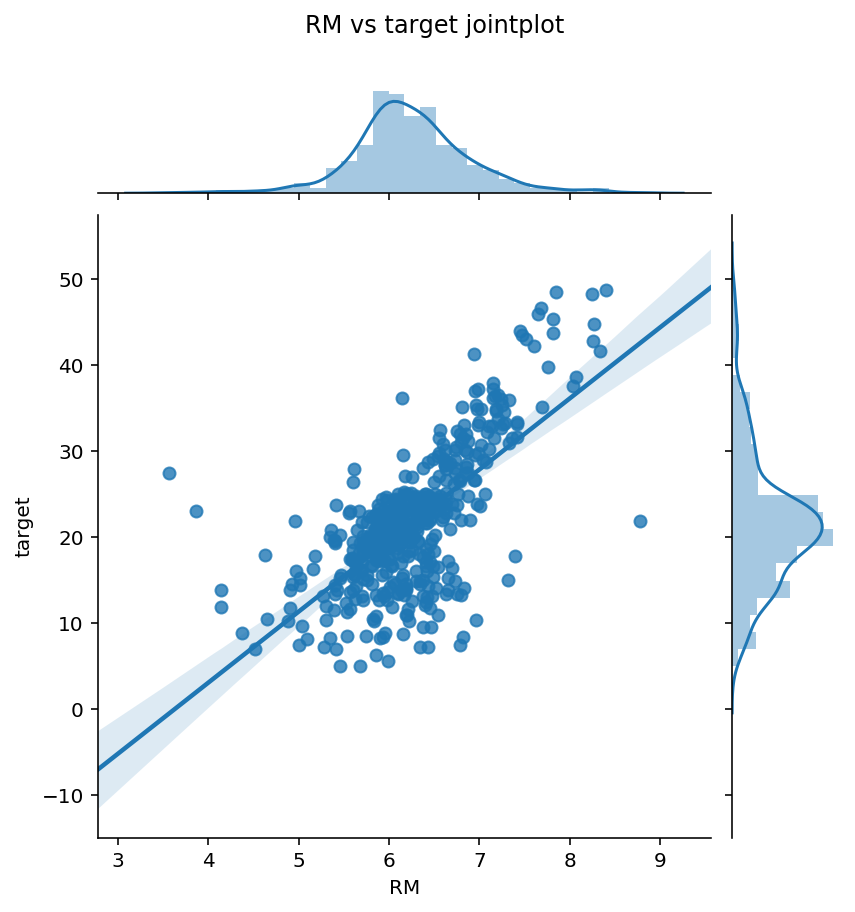

In [6]:
sns.jointplot("RM", "target", data=df, kind='reg');
plt.suptitle("RM vs target jointplot", y = 1.05);

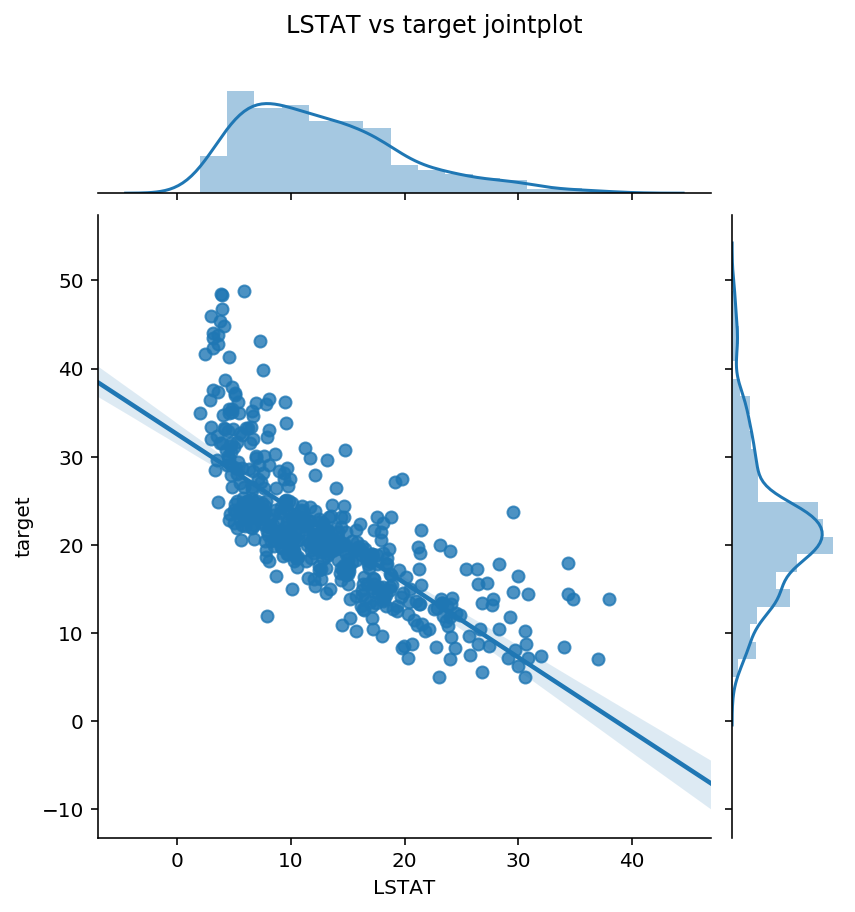

In [7]:
sns.jointplot("LSTAT", "target", data=df, kind='reg');
plt.suptitle("LSTAT vs target jointplot", y = 1.05);

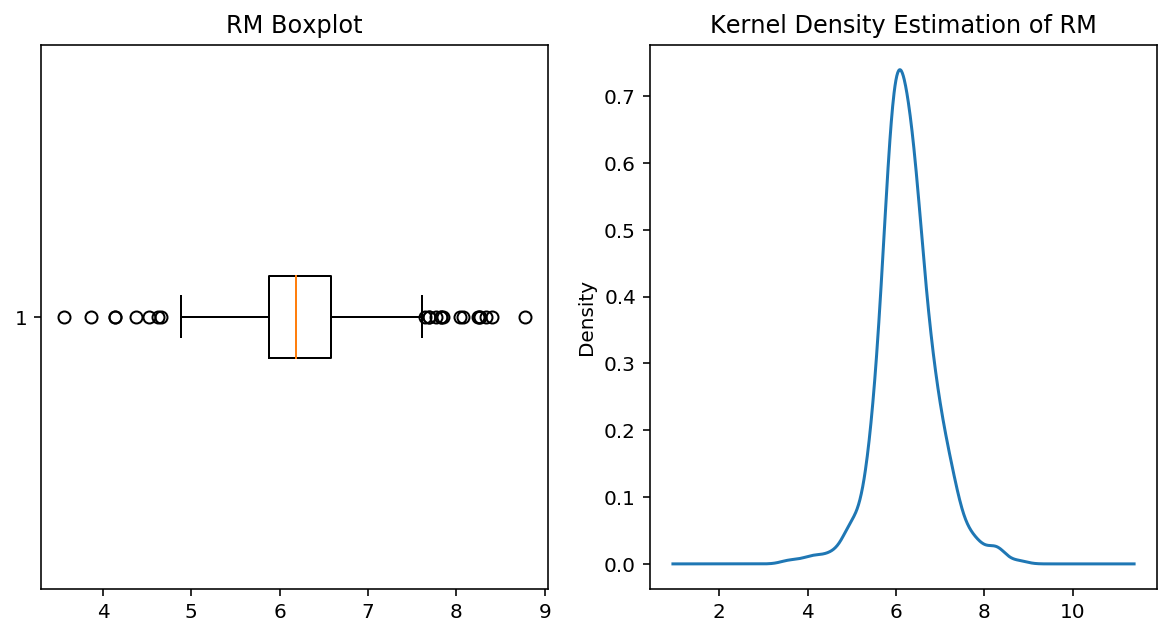

In [8]:
fig1, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5));
ax[0].set_title('RM Boxplot');
ax[0].boxplot(df["RM"], vert=False);

ax[1].set_title("Kernel Density Estimation of RM");
df["RM"].plot.kde(ax = ax[1]);

In [9]:
df[(df["RM"] < 4) | (df["RM"] > 8.75)]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
364,3.47428,0.0,18.1,1.0,0.718,8.780,82.9,1.9047,24.0,666.0,20.2,354.55,5.29,21.9
365,4.55587,0.0,18.1,0.0,0.718,3.561,87.9,1.6132,24.0,666.0,20.2,354.70,7.12,27.5
367,13.52220,0.0,18.1,0.0,0.631,3.863,100.0,1.5106,24.0,666.0,20.2,131.42,13.33,23.1


<div class="alert alert-block alert-info">
    <strong>Removing Outliers</strong>
<br><br>
Given that RM homes with less than 4 rooms or greater than 8.75 rooms are rare, we will also remove these values from the dataframe. 
</div>

In [10]:
print("Original length of dataset: {}".format(len(X)))
print("Current length of dataset: {}".format(len(df[(df["RM"] >= 4) & (df["RM"] <= 8.75)])))

Original length of dataset: 506
Current length of dataset: 487


In [11]:
df = df[(df["RM"] >= 4) & (df["RM"] <= 8.75)]

# 3. Ordinary Least Squares <a id = "rm"></a>

#### 3A. Model 1: OLS on RM Column<a id = "rm"></a>

In [12]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#Define Range and Domain

X1 = df[["RM"]]
y1 = df["target"]

#Train/Test/Split Range and Domain

X_train, X_test, y_train, y_test = train_test_split(X1,y1, random_state = 88)

#Instantiate model 

lr = LinearRegression()

#Test Cross Validation Scores
cross_val_score(lr,X_train, y_train, cv = 5)

array([0.4408982 , 0.63681981, 0.45081936, 0.54587115, 0.31592723])

In [13]:
#Fit Model
lr.fit(X_train,y_train)
model_1 = lr.score(X_test,y_test)

#Test Model
pred = lr.predict(X_test)

#Define residuals and linear function
residuals = y_test - pred
yhat = X_test*lr.coef_[0]+lr.intercept_

print("R^2 of model 1: {}".format(round(model_1,3)))

R^2 of model 1: 0.621


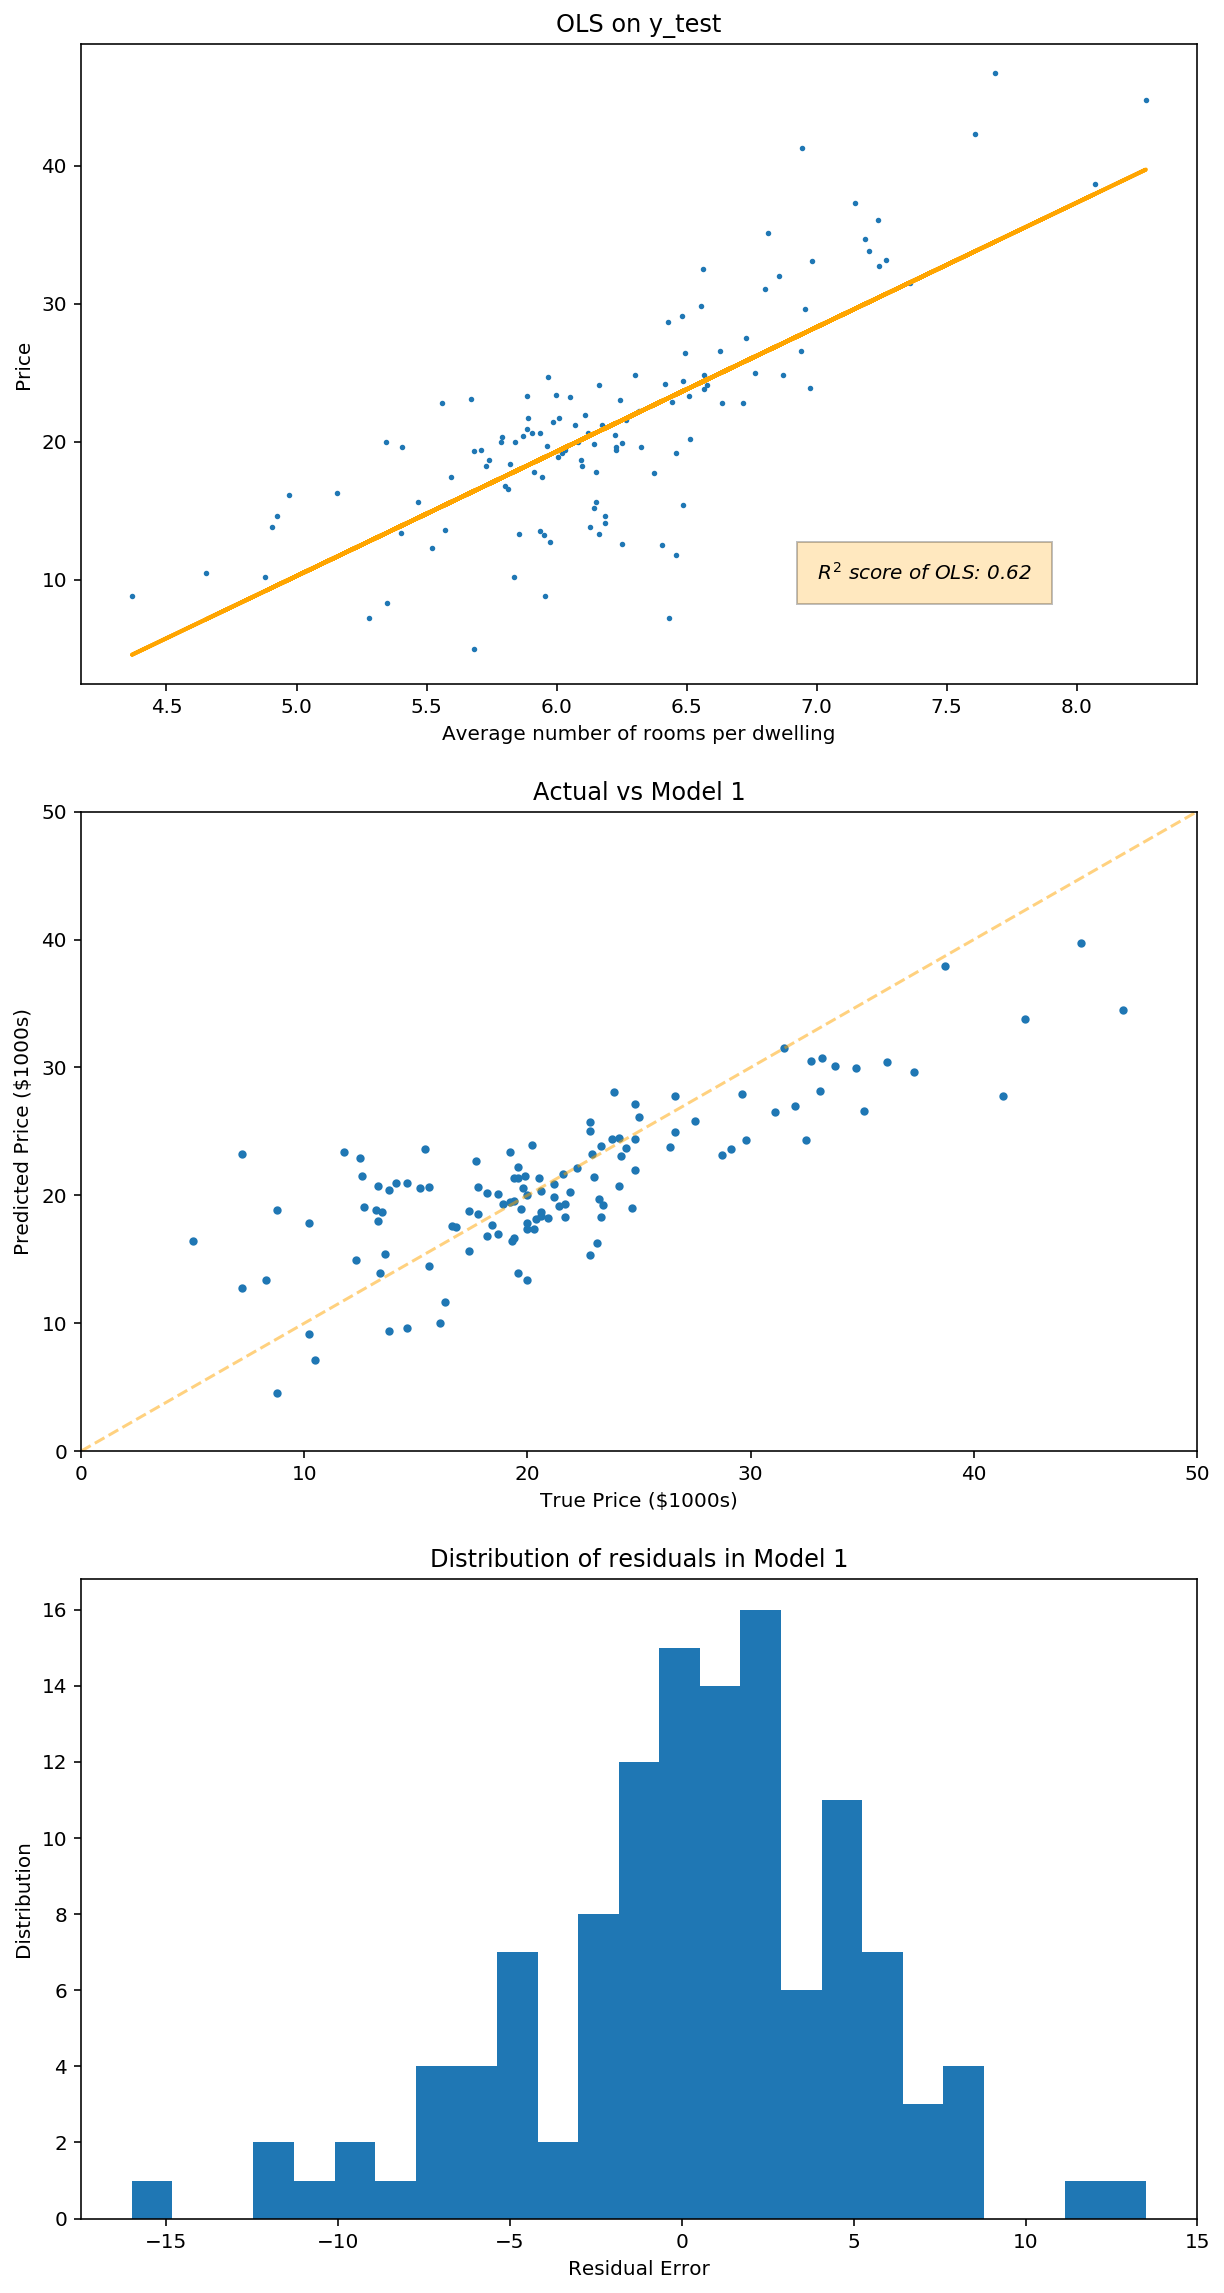

In [14]:
figure, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 20)) 

ax[0].scatter(X_test,y_test, s = 3);
ax[0].plot(X_test,yhat, lw=2, c='orange', label ='regression line');
ax[0].set_xlabel("Average number of rooms per dwelling");
ax[0].set_ylabel('Price');
ax[0].set_title("OLS on y_test");
ax[0].text(7, 10, '${}${}{}'.format('R^2'," score of OLS: ",str(round(r2_score(y_test,pred),2))), style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.25, 'pad': 10});


ax[1].plot([0, 50], [0, 50], color = "orange", alpha = .5, ls='--')
ax[1].scatter(y_test, pred, s = 10);
ax[1].set_ylim((0,50))
ax[1].set_xlim((0,50))
ax[1].set_xlabel('True Price ($1000s)');
ax[1].set_ylabel('Predicted Price ($1000s)');
ax[1].set_title("Actual vs Model 1");


ax[2].hist(residuals, bins = 25);
ax[2].set_xlabel('Residual Error');
ax[2].set_ylabel('Distribution');
ax[2].set_title("Distribution of residuals in Model 1");

#### 3B. Model 2: Ridge on Log of LSTAT Column<a id = "lstat"></a>

In [15]:
from sklearn.linear_model import RidgeCV
#Define Range and Domain

X2 = np.log(df[["LSTAT"]])
y2 = df["target"]

#Train/Test/Split Range and Domain

X_train, X_test, y_train, y_test = train_test_split(X2,y2, random_state = 88)

#Instantiate model 

ridge = RidgeCV()

#Test Cross Validation Scores
cross_val_score(ridge,X_train, y_train, cv = 5)

array([0.60087178, 0.74554662, 0.5473587 , 0.62139172, 0.66308177])

In [16]:
#Fit Model
ridge.fit(X_train,y_train)
model_2 = ridge.score(X_test,y_test)

#Test Model
pred = ridge.predict(X_test)

#Define residuals and linear function
residuals = y_test - pred
yhat = X_test*ridge.coef_[0]+ridge.intercept_

print("R^2 of model 2: {}".format(round(model_2,3)))

R^2 of model 2: 0.737


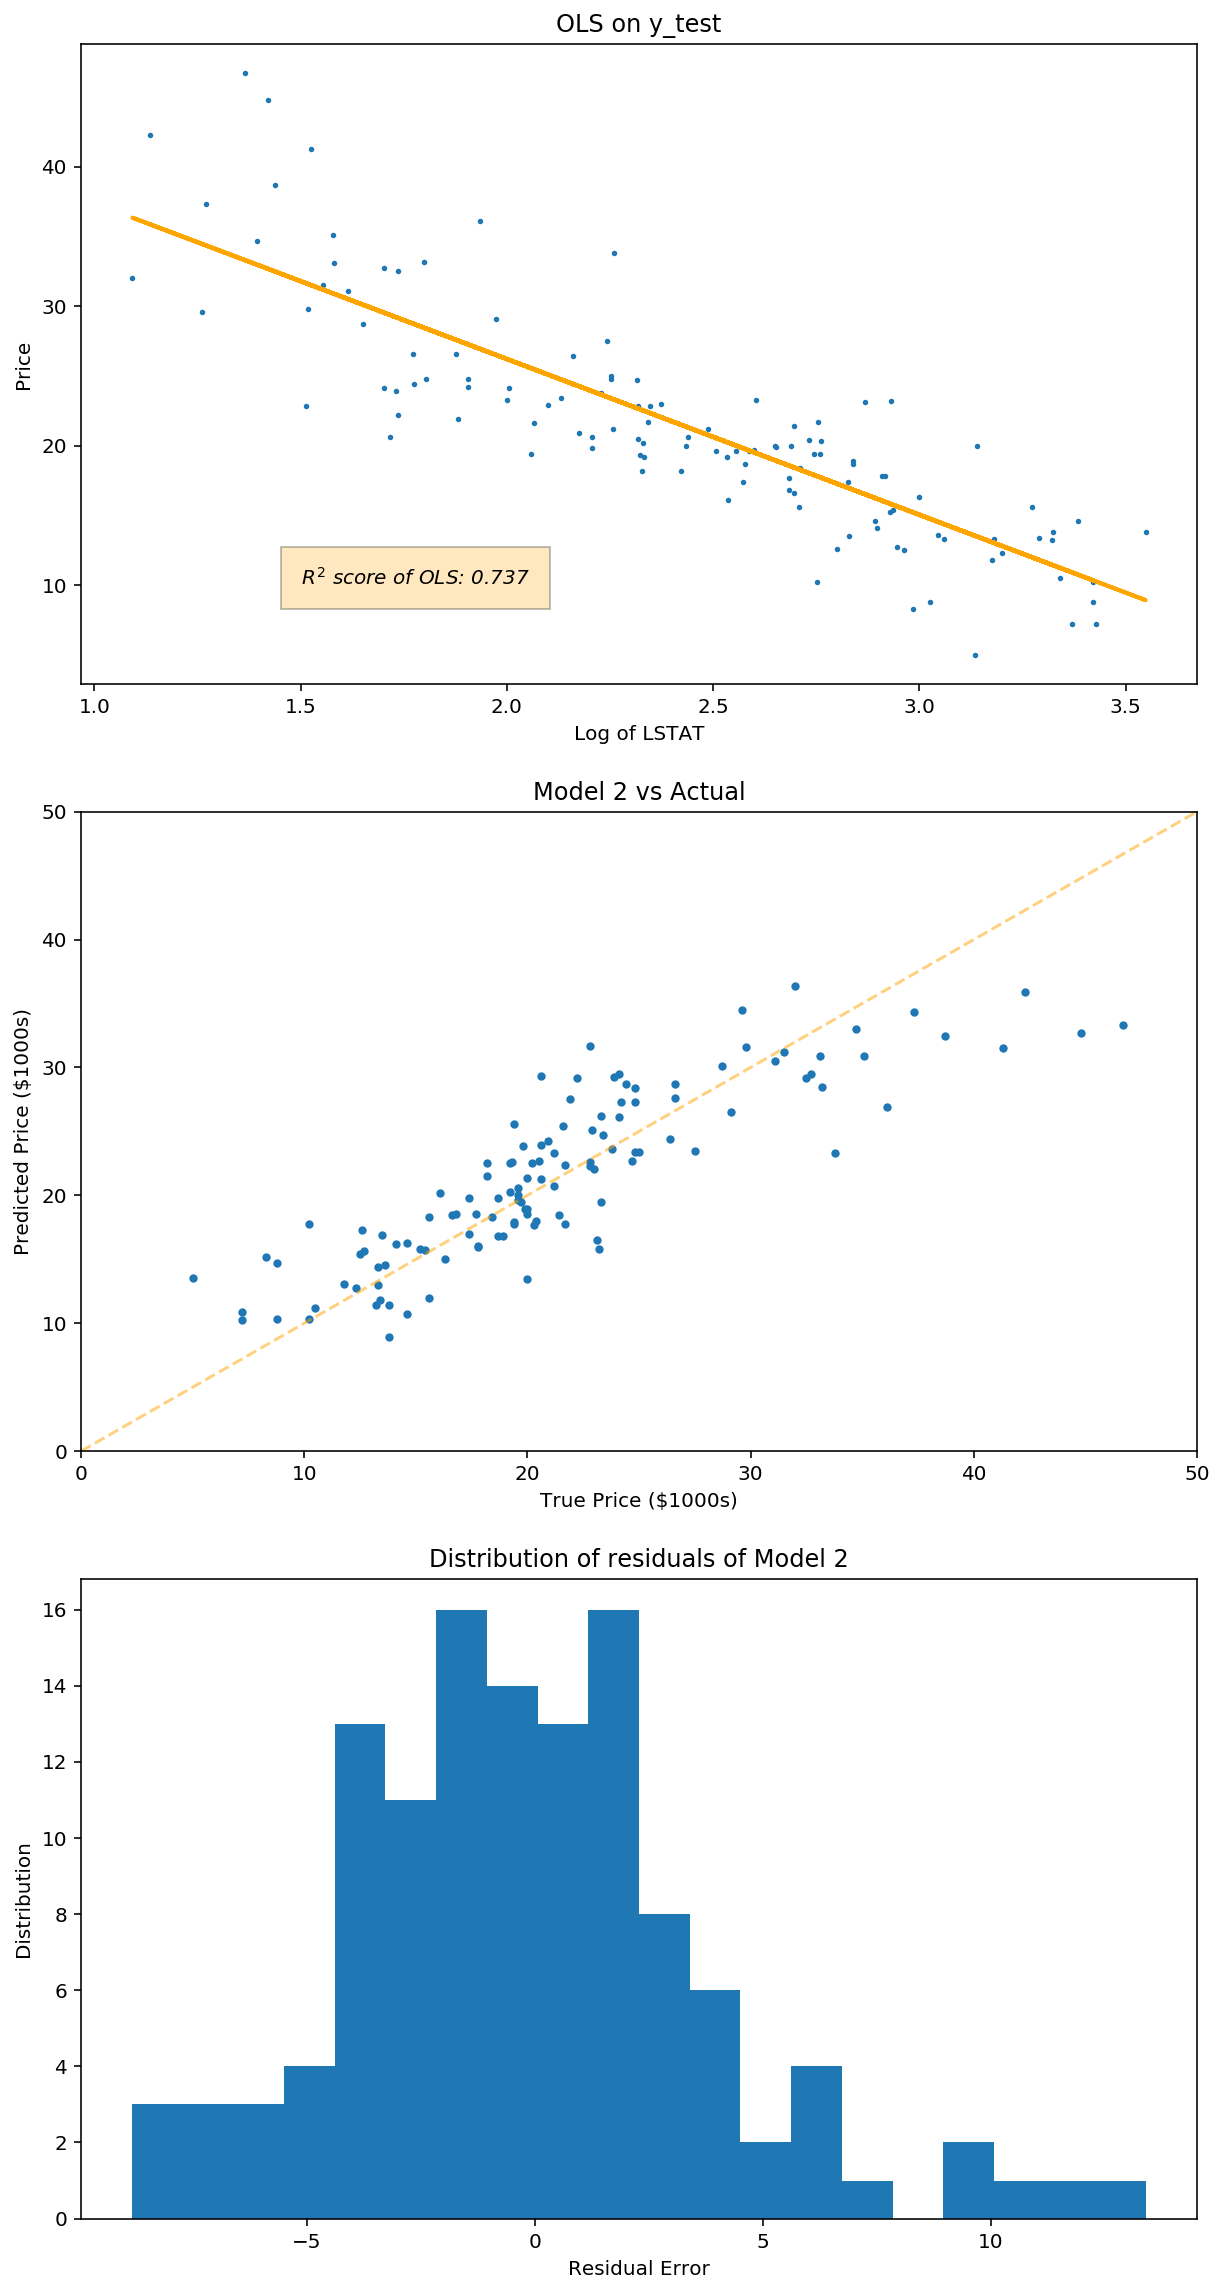

In [17]:
figure, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 20)) 

ax[0].scatter(X_test,y_test, s = 3);
ax[0].plot(X_test,yhat, lw=2, c='orange', label ='regression line');
ax[0].set_xlabel("Log of LSTAT");
ax[0].set_ylabel('Price');
ax[0].set_title("OLS on y_test");
ax[0].text(1.5, 10, '${}${}{}'.format('R^2'," score of OLS: ",str(round(r2_score(y_test,pred),3))), style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.25, 'pad': 10});

ax[1].plot([0, 50], [0, 50], color = "orange", alpha = .5, ls='--')
ax[1].scatter(y_test, pred, s = 10);
ax[1].set_ylim((0,50))
ax[1].set_xlim((0,50))
ax[1].set_xlabel('True Price ($1000s)');
ax[1].set_ylabel('Predicted Price ($1000s)');
ax[1].set_title("Model 2 vs Actual");

ax[2].hist(residuals, bins = 20);
ax[2].set_xlabel('Residual Error');
ax[2].set_ylabel('Distribution');
ax[2].set_title("Distribution of residuals of Model 2");

# 4. Other Single Column Regressions <a id = "pm"></a>

In [18]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor, HuberRegressor

#### 4A. Model 3: 5th Order Polynomial Regression on LSTAT<a id = "rls"></a>

In [19]:
#Define Range and Domain

X3 = np.log(df[["LSTAT"]])
y3 = df["target"]

# Instantiate our PolynomialFeatures object to create all two-way terms.
poly = PolynomialFeatures(degree=5,
                          interaction_only=False,
                          include_bias=True)

X_overfit = pd.DataFrame(poly.fit_transform(X3),columns=poly.get_feature_names(X3.columns))

#Train/Test/Split Range and Domain
X_train, X_test, y_train, y_test = train_test_split(X_overfit,y3, random_state = 88)

#Instantiate models 

lr = LinearRegression()
ridge = RidgeCV()
reg = RANSACRegressor(random_state = 88)
thel = TheilSenRegressor(random_state = 88)
huber = HuberRegressor(max_iter=1000,)

#Model results
print("Linear Regression:\t" ,cross_val_score(lr,  ,y_train, cv = 5))
print("RidgeCV:\t\t", cross_val_score(ridge, X_train,y_train, cv = 5))
print("RANSAC Regressor:\t", cross_val_score(reg, X_train,y_train, cv = 5))
print("TheilSen Regressor:\t", cross_val_score(thel, X_train,y_train, cv = 5))
print("Huber Regressor:\t", cross_val_score(huber, X_train,y_train, cv = 5))


Linear Regression:	 [0.60864264 0.76371145 0.52378856 0.63425988 0.66473139]
RidgeCV:		 [0.60392393 0.72843358 0.48555561 0.61179426 0.66399539]
RANSAC Regressor:	 [ 0.47923538  0.4620839  -3.25269885  0.58611701 -1.19867403]
TheilSen Regressor:	 [ 0.58007313  0.72790783 -0.05579252  0.63968638  0.57543568]
Huber Regressor:	 [0.58896565 0.72397964 0.23499279 0.6023036  0.63756092]


In [20]:
#Fit Model
lr.fit(X_train,y_train)
model_3 = lr.score(X_test,y_test)

#Test Model
pred = lr.predict(X_test)

#Define residuals and linear function
residuals = y_test - pred

print("R^2 of model 3: {}".format(round(model_3,3)))

R^2 of model 3: 0.753


In [21]:
#Polynomial Plot Setup

plot = X_test.copy()
plot = plot.assign(pred=pd.Series(pred).values)
plot = plot.assign(actual=pd.Series(y_test).values)
plot = plot.sort_values("LSTAT")

coef = list(lr.coef_)
coef[0] = lr.intercept_

def polyplot(x):

    o = len(coef)
    y = 0
    for i in range(o):
        y += coef[i]*x**i
    return y

x = np.linspace(plot.iloc[0,1], plot.iloc[len(plot) - 1,1], 100)

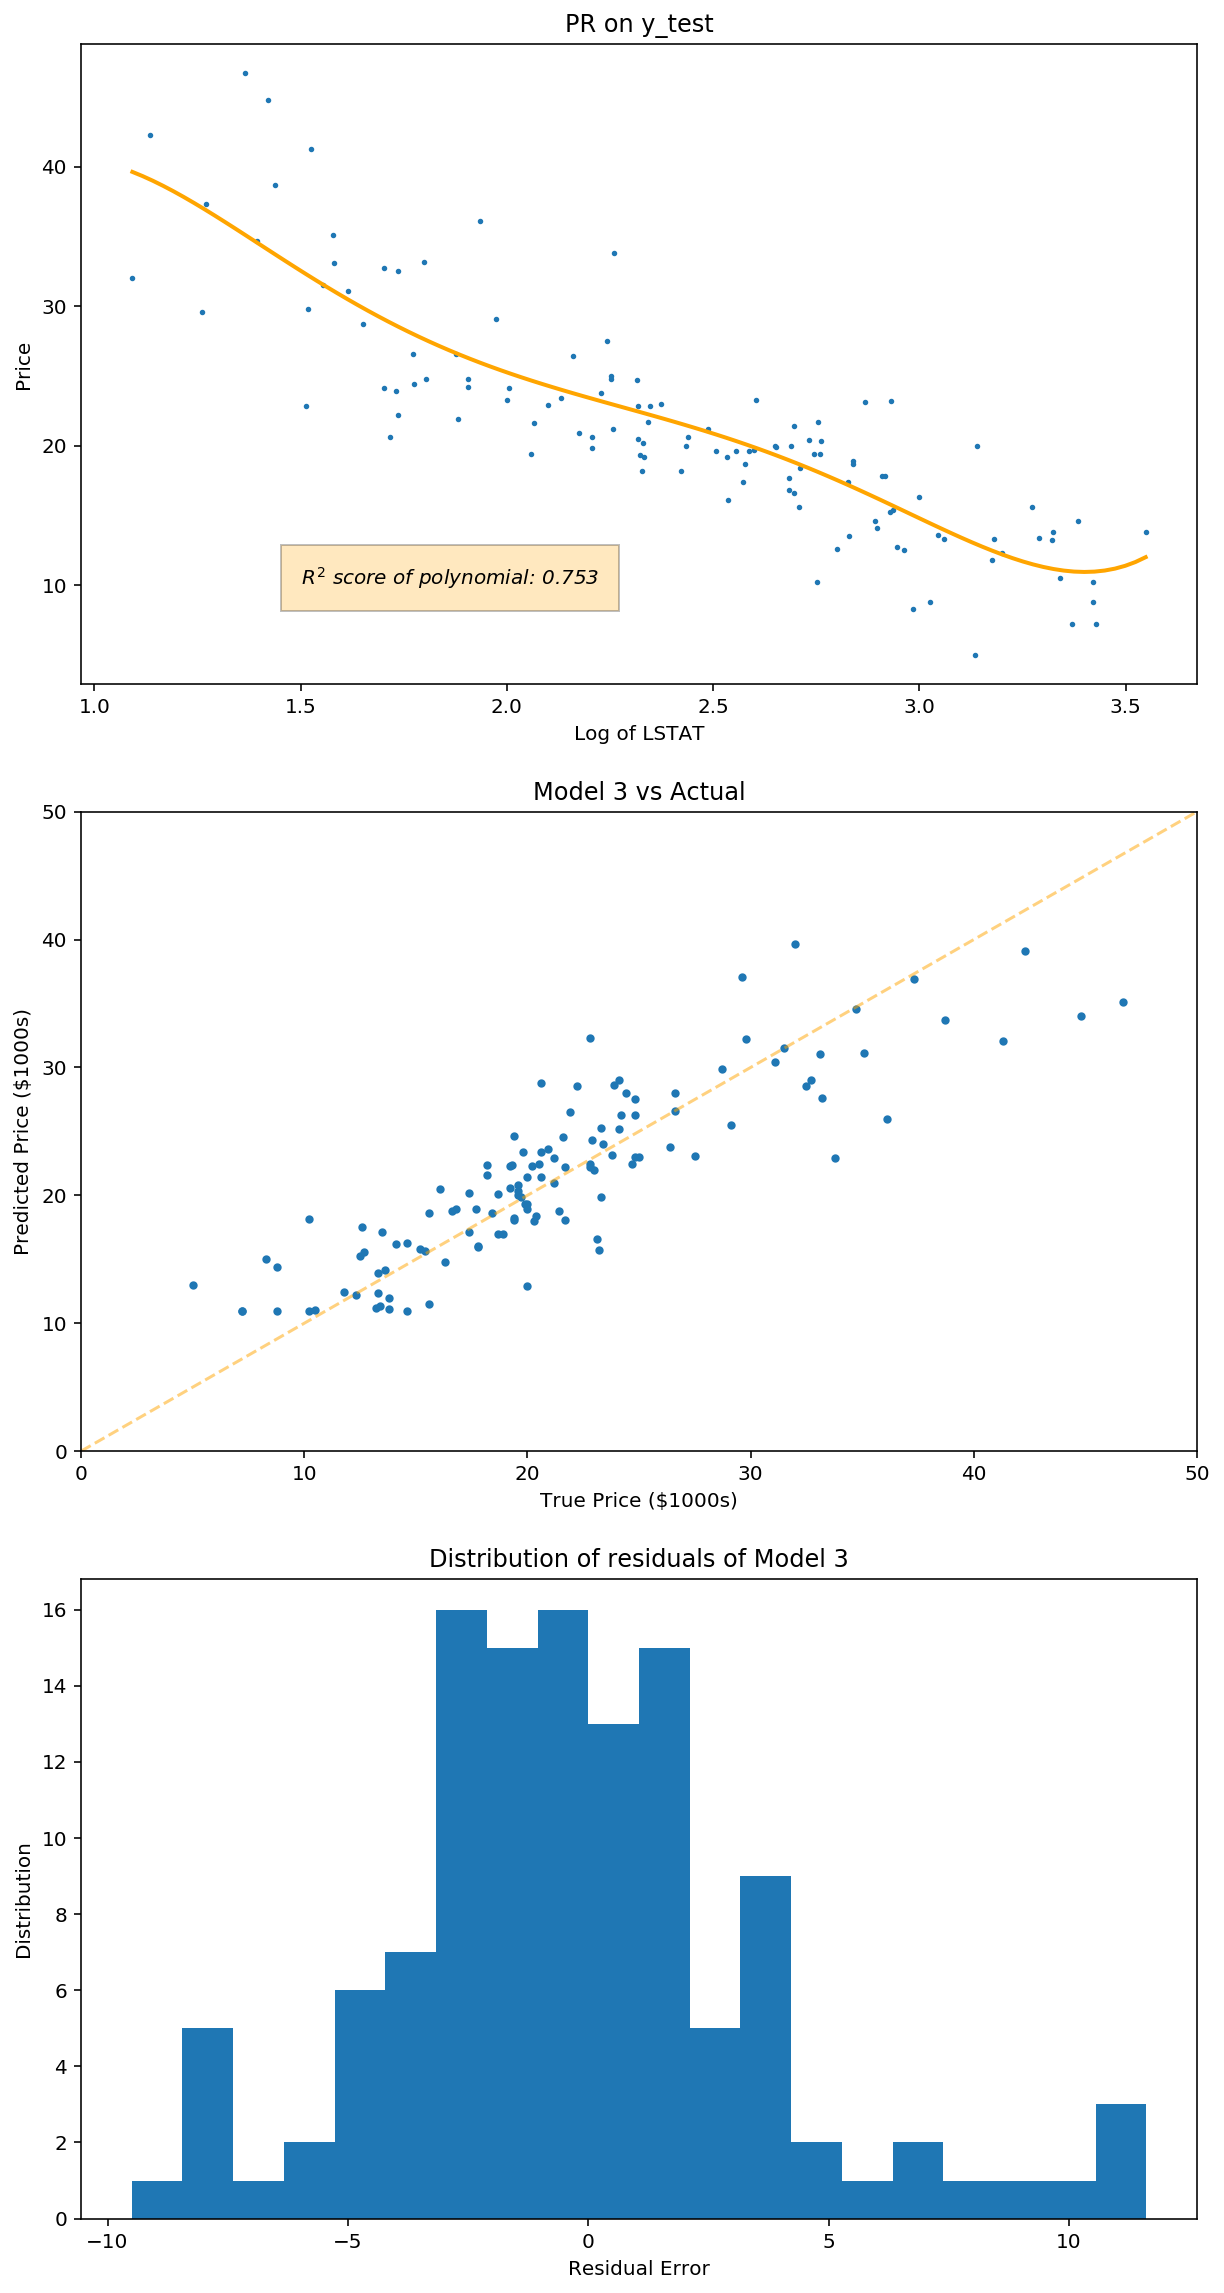

In [22]:
figure, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 20)) 

ax[0].scatter(plot["LSTAT"],plot["actual"], s = 3);
ax[0].plot(x, polyplot(x), lw=2, c='orange', label ='regression line');
ax[0].set_xlabel("Log of LSTAT");
ax[0].set_ylabel('Price');
ax[0].set_title("PR on y_test");
ax[0].text(1.5, 10, '${}${}{}'.format('R^2'," score of polynomial: ",str(round(r2_score(y_test,pred),3))), style='italic',
         bbox={'facecolor': 'orange', 'alpha': 0.25, 'pad': 10});

ax[1].plot([0, 50], [0, 50], color = "orange", alpha = .5, ls='--')
ax[1].scatter(y_test, pred, s = 10);
ax[1].set_ylim((0,50))
ax[1].set_xlim((0,50))
ax[1].set_xlabel('True Price ($1000s)');
ax[1].set_ylabel('Predicted Price ($1000s)');
ax[1].set_title("Model 3 vs Actual");

ax[2].hist(residuals, bins = 20);
ax[2].set_xlabel('Residual Error');
ax[2].set_ylabel('Distribution');
ax[2].set_title("Distribution of residuals of Model 3");

# 5. Multi Column Regressions <a id = "mcr"></a>

In [23]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


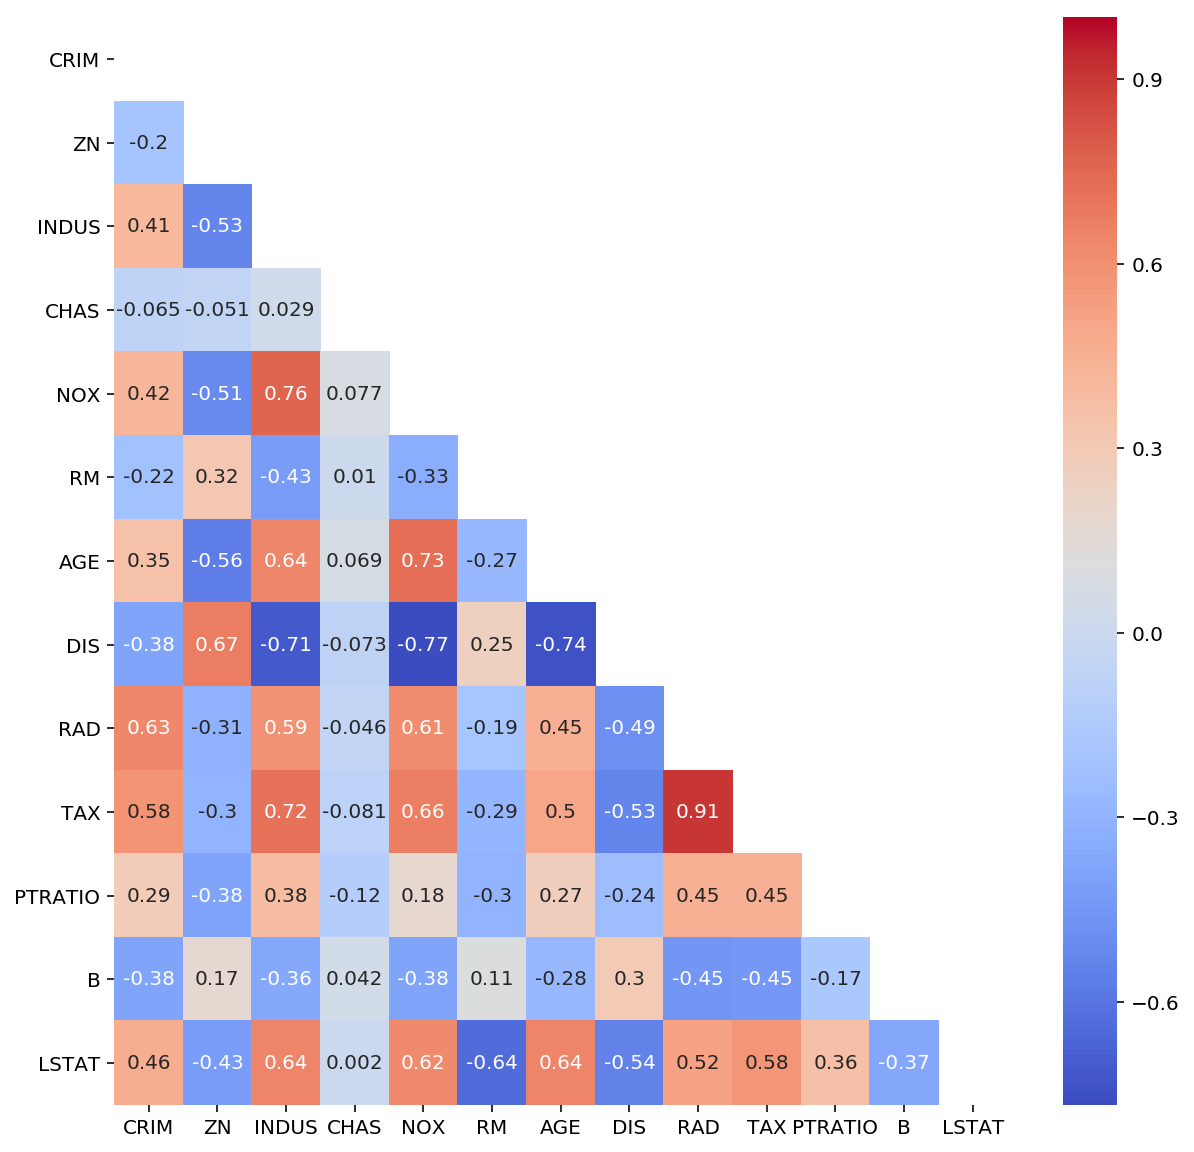

In [24]:
X = df.loc[:, df.columns != "target"]
y = df["target"]

# Generate a heatmap in seaborn.
# This code is pulled from https://seaborn.pydata.org/generated/seaborn.heatmap.html.

# Set the default matplotlib figure size to 12x12:
fix, ax = plt.subplots(figsize=(10,10))

# Generate a mask for the upper triangle.
mask = np.zeros_like(X.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(X.corr(), mask=mask, ax=ax, annot=True, cmap='coolwarm')

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10);

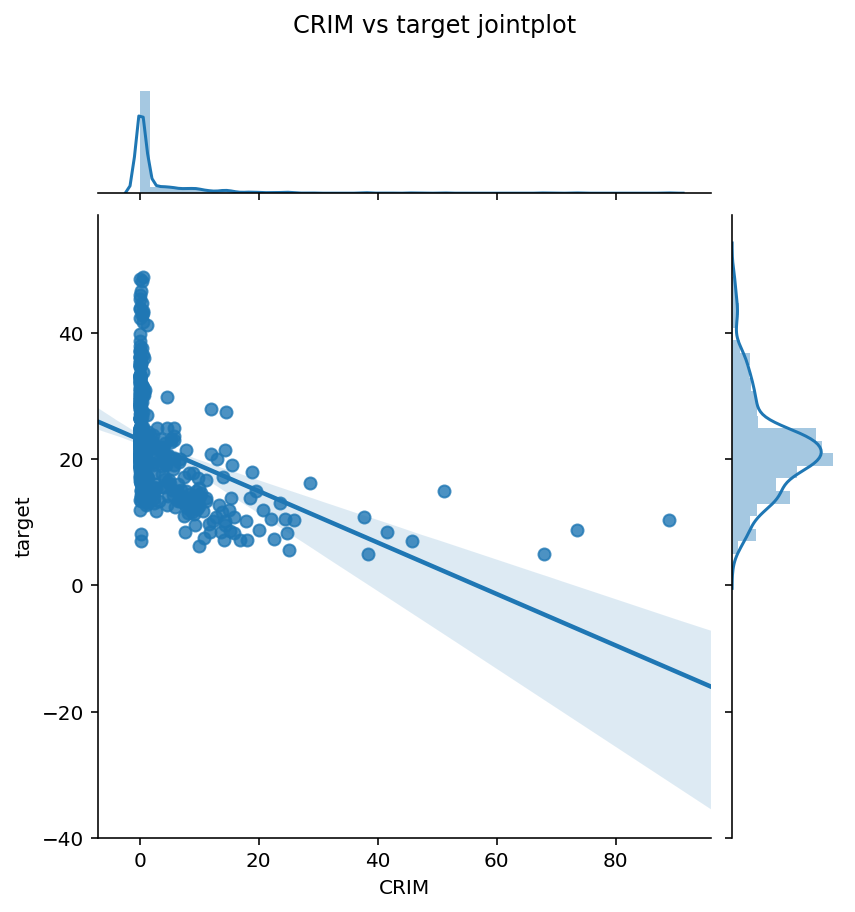

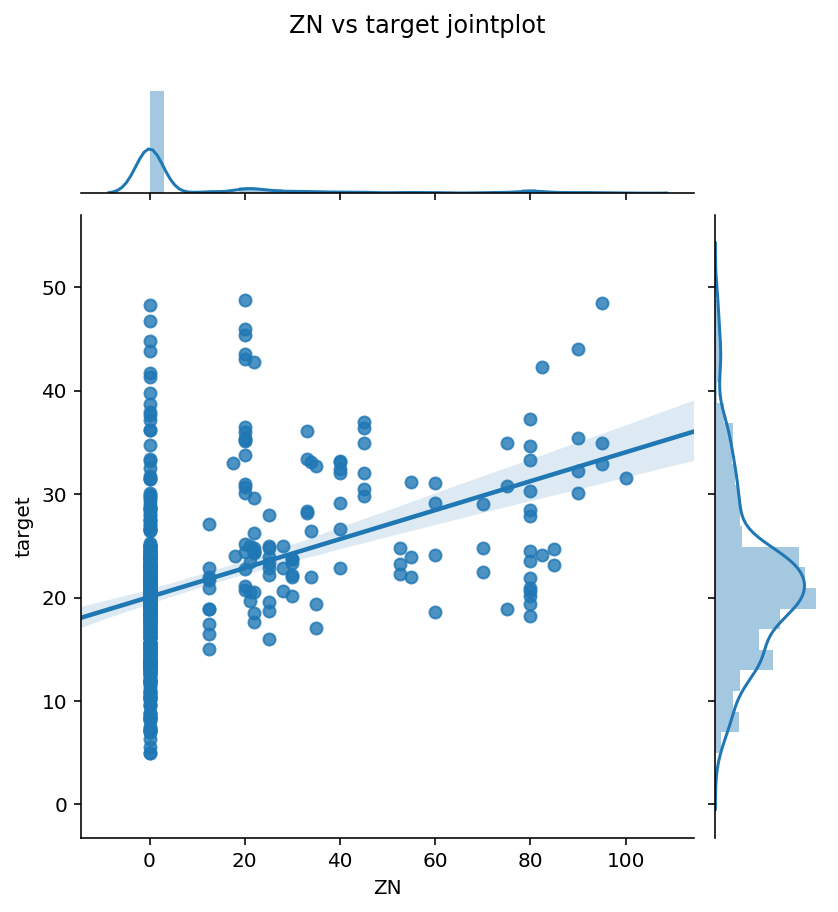

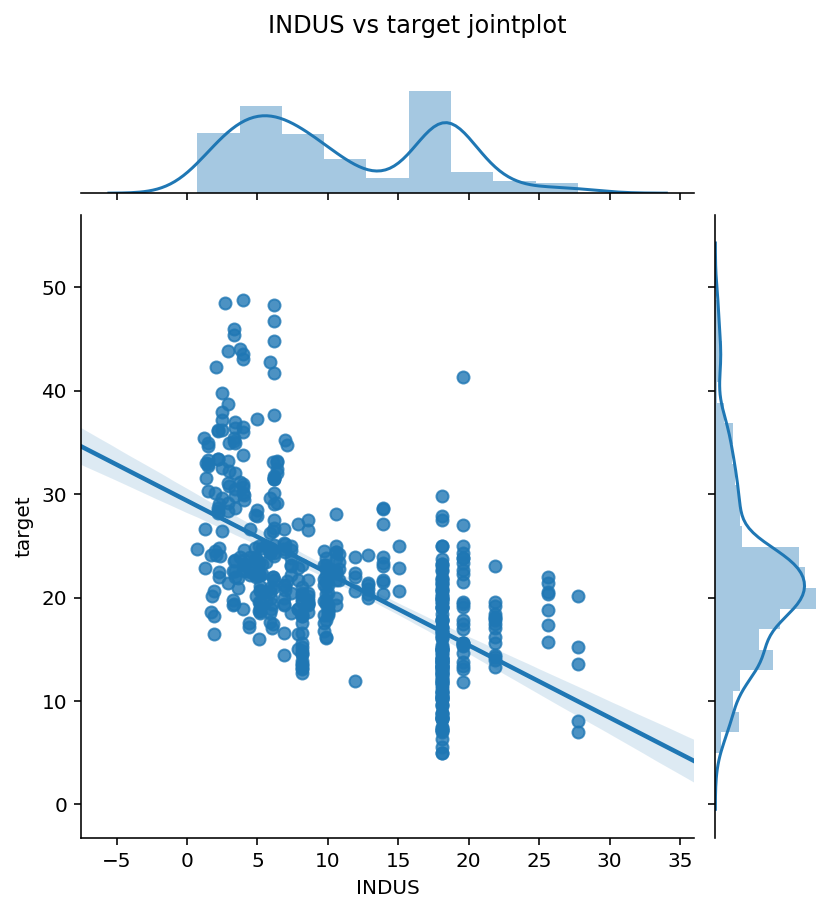

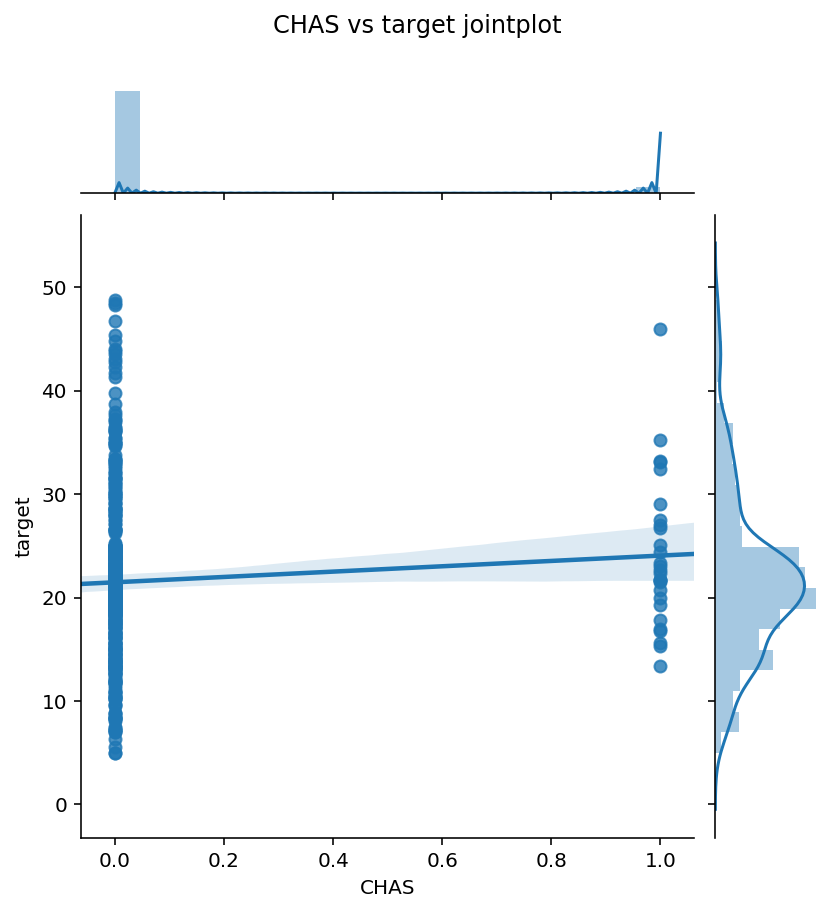

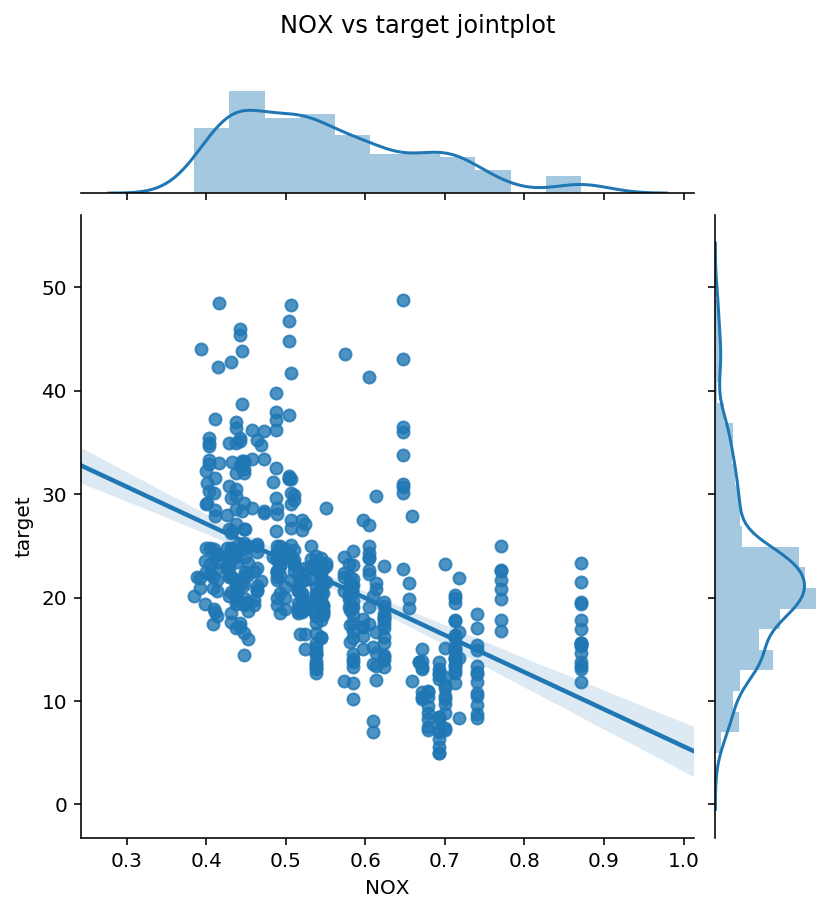

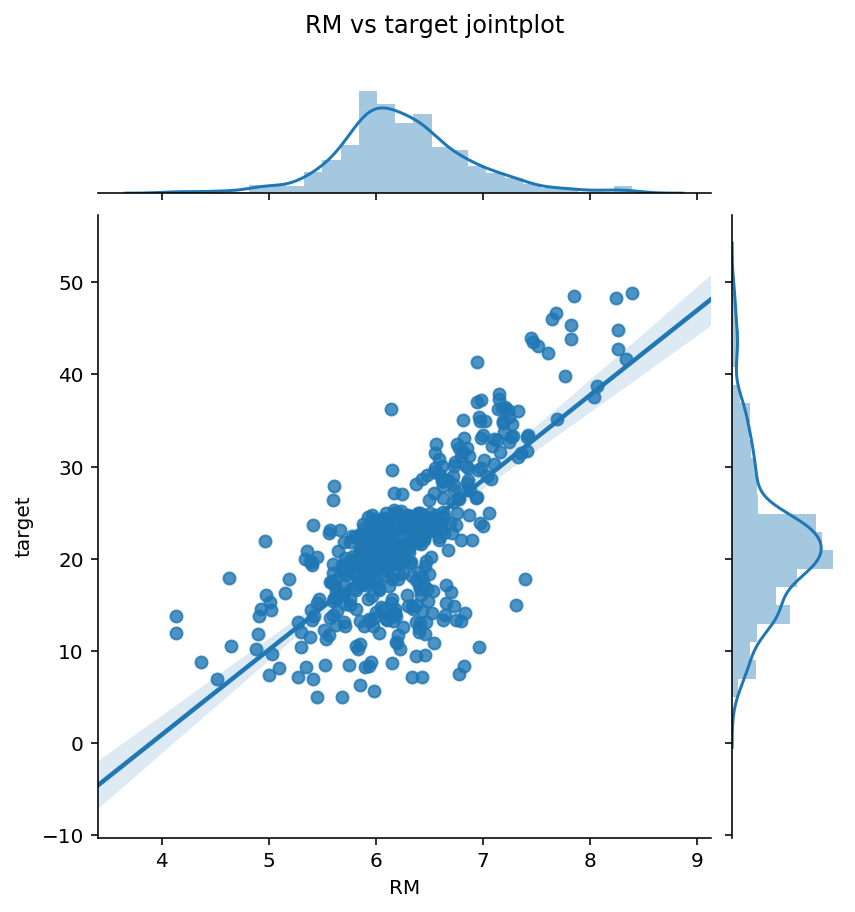

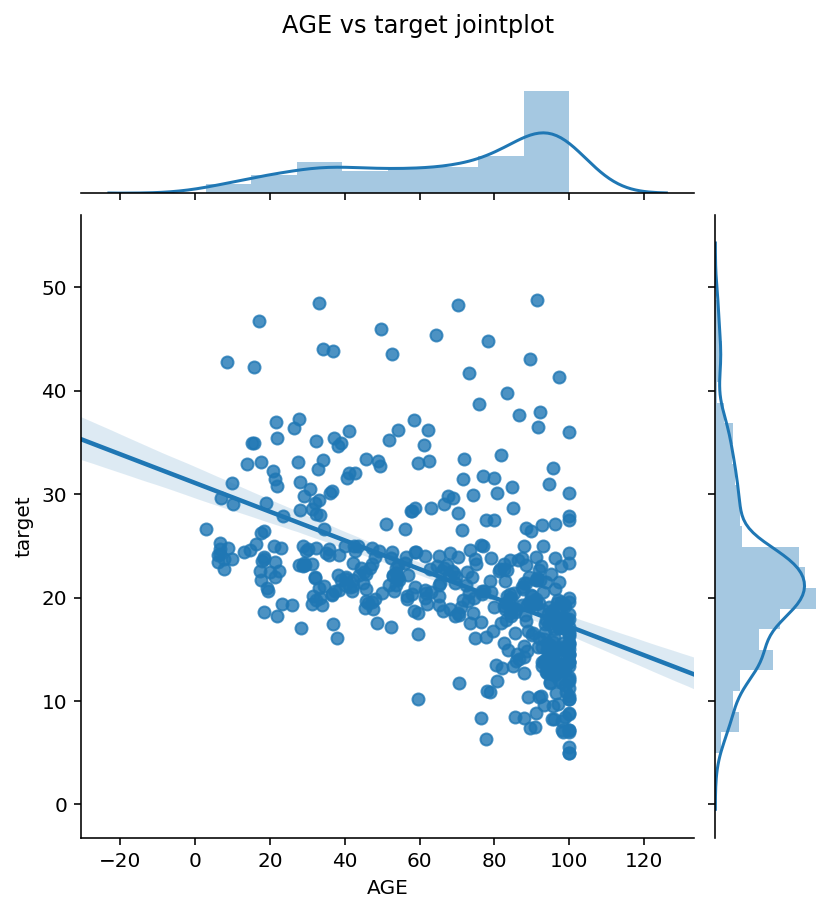

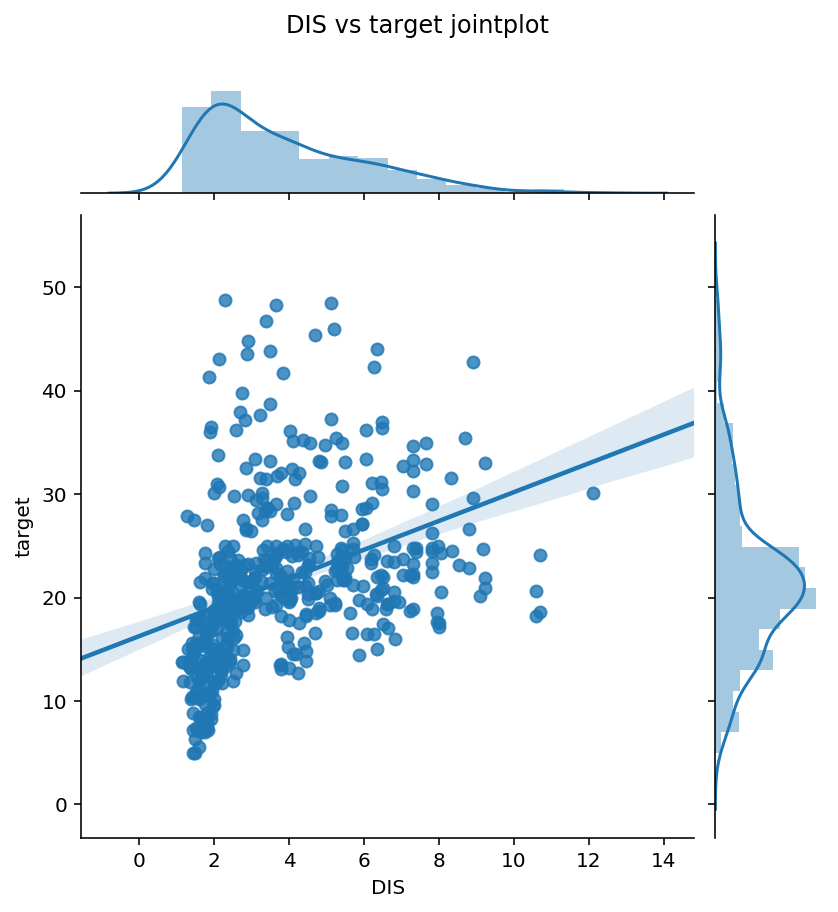

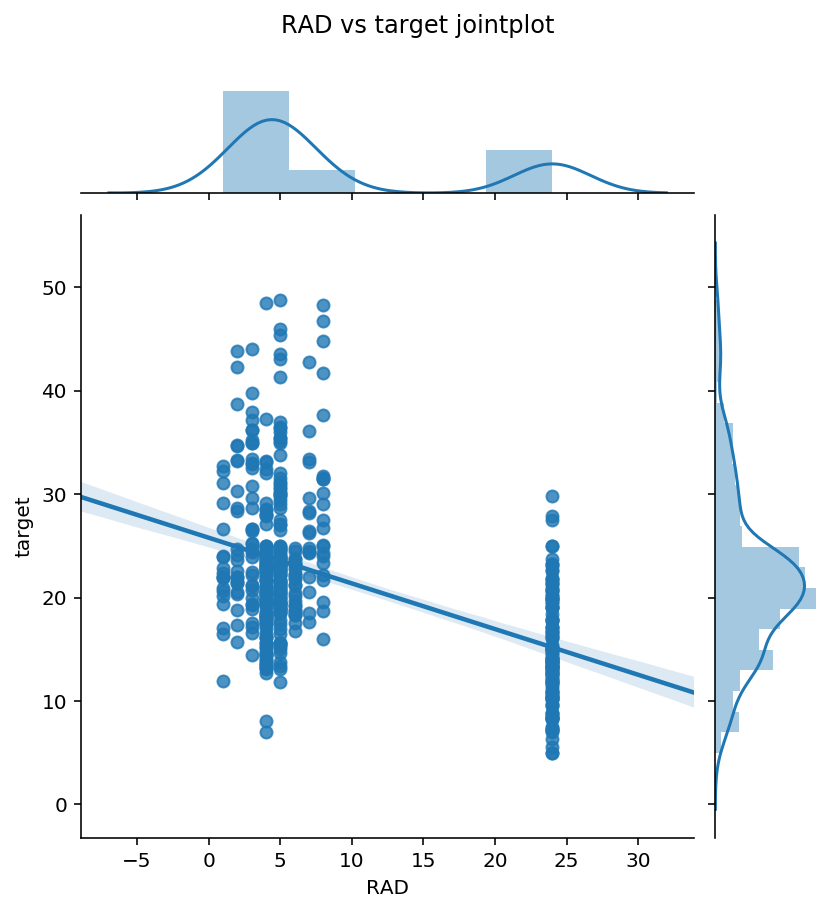

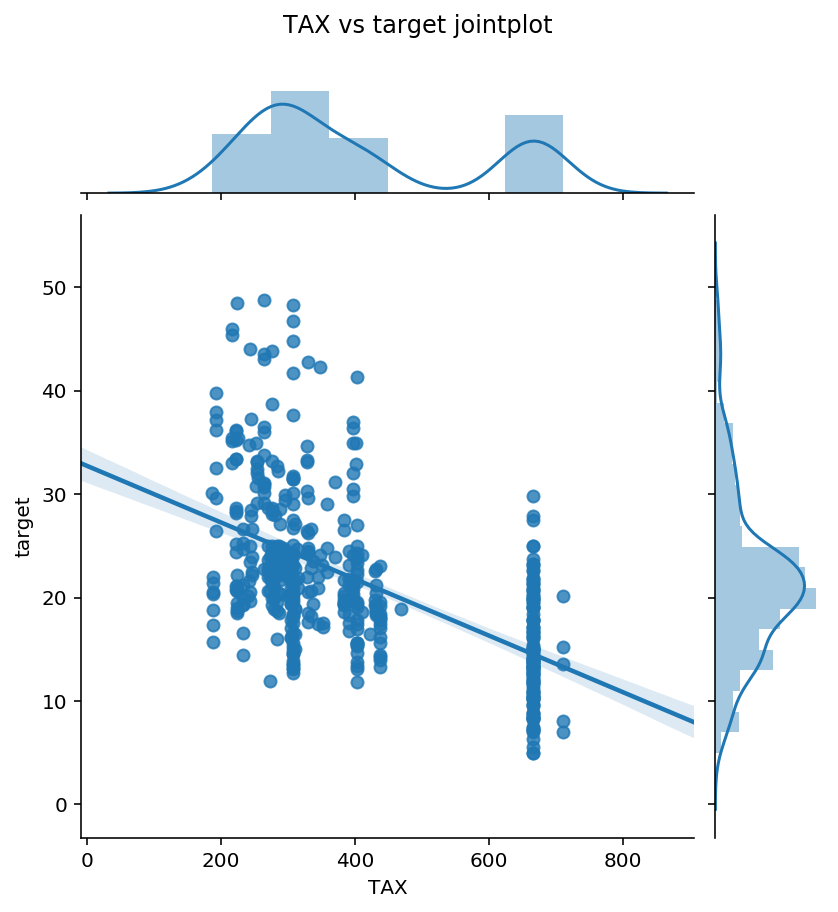

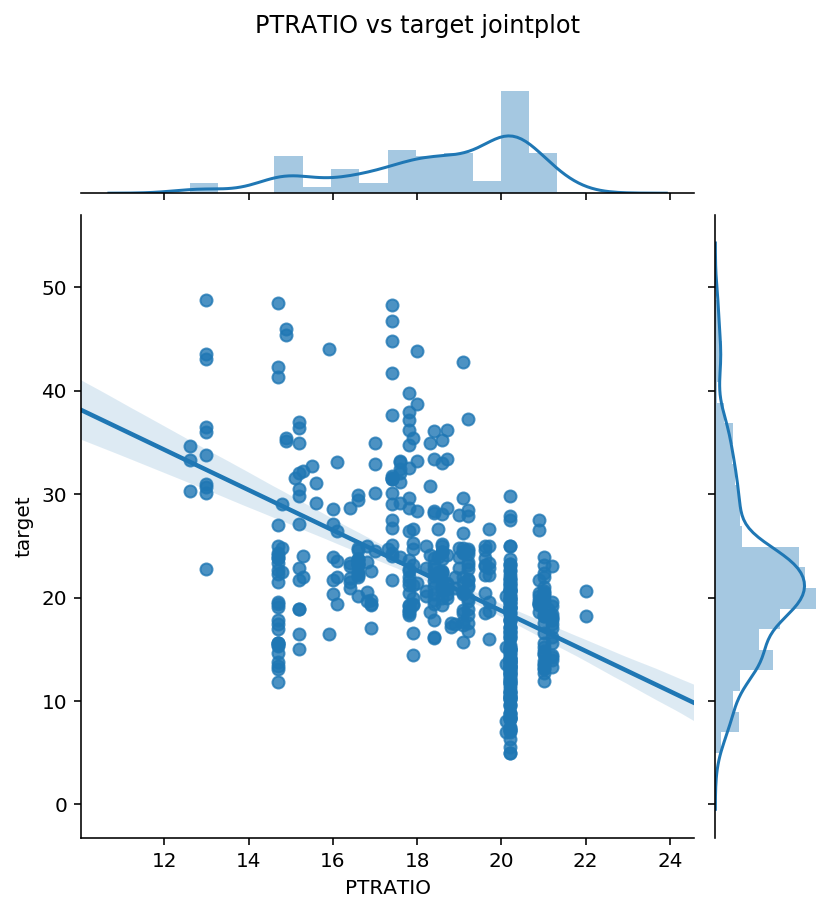

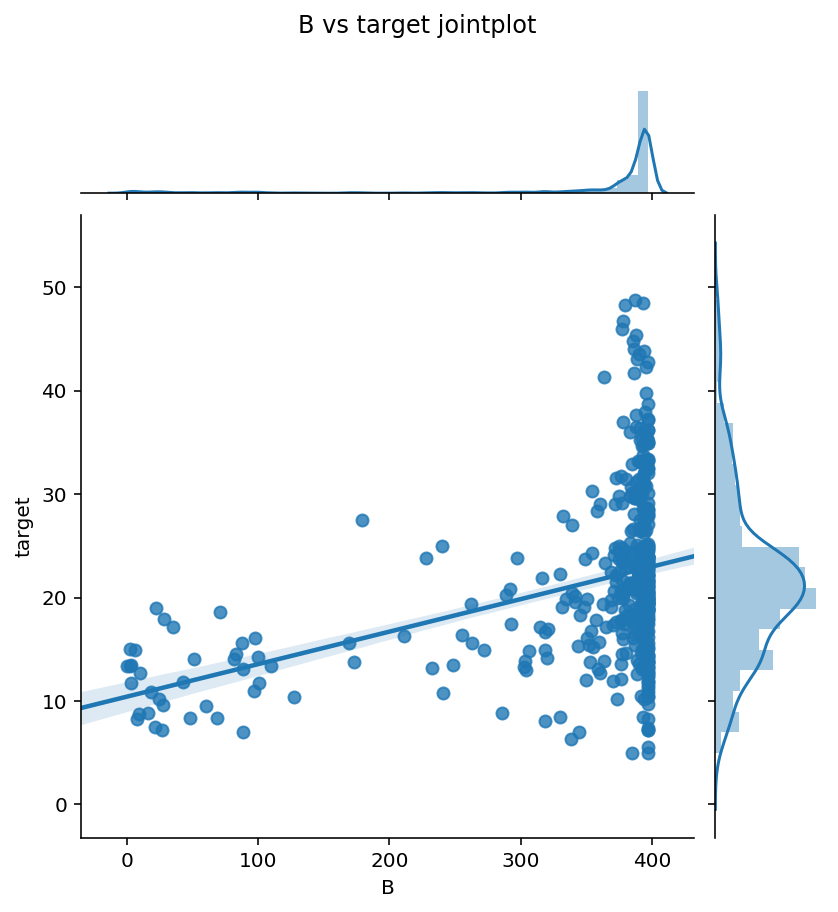

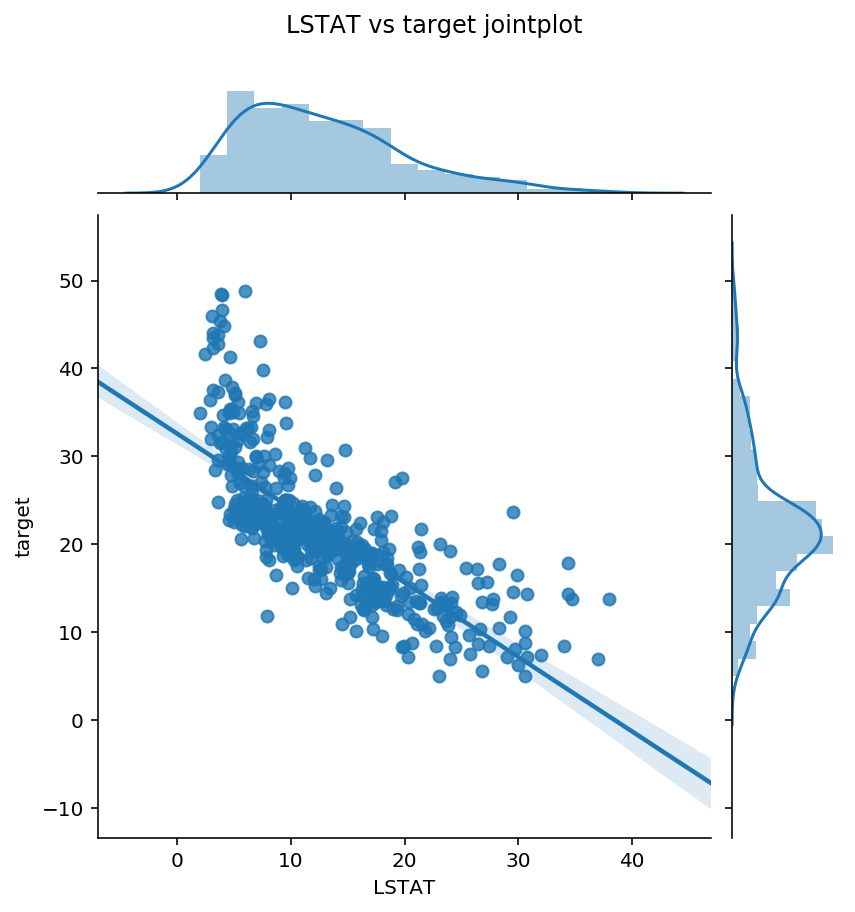

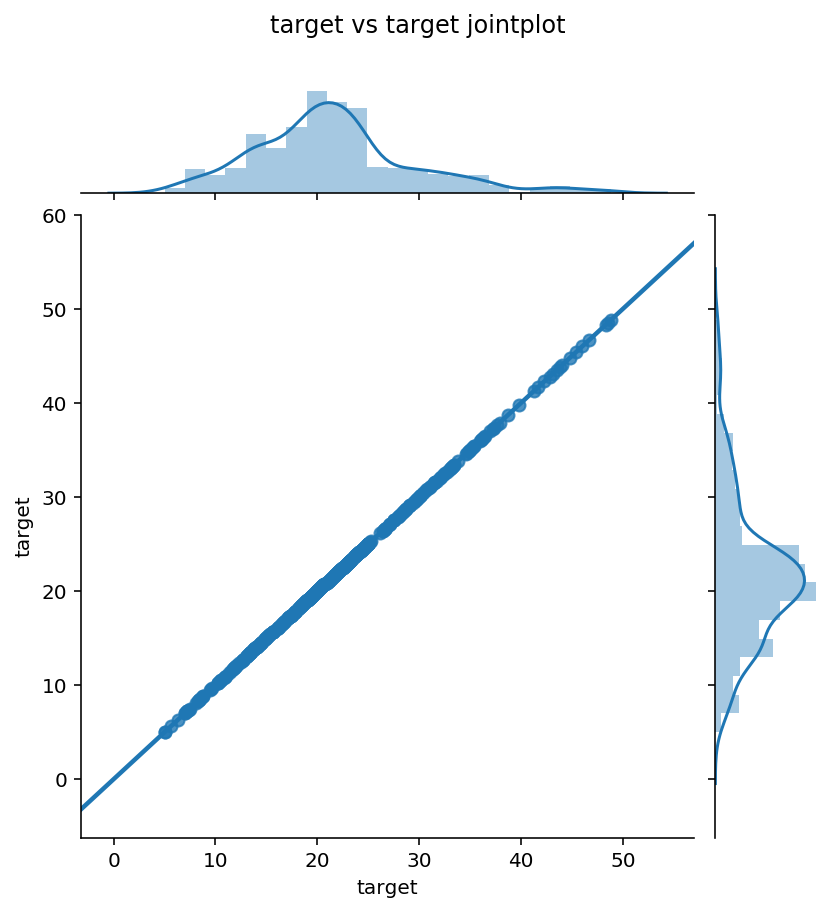

In [25]:
for i in df.columns.values:
    sns.jointplot(i, "target", data=df, kind='reg');
    plt.suptitle("{} vs target jointplot".format(i), y = 1.05);

In [26]:
# Instantiate our PolynomialFeatures object to create all two-way terms.
poly = PolynomialFeatures(degree=2,
                          interaction_only=False,
                          include_bias=True)

# Fit and transform our X data.
X_overfit = pd.DataFrame(poly.fit_transform(X),columns=poly.get_feature_names(X.columns))

# Instantiate Standard Scaler.
X_Scaled_overfit = StandardScaler()

# Fit AND transform Standard Scaler to overfit data in one step.
X_Scaled_overfit = pd.DataFrame(X_Scaled_overfit.fit_transform(X_overfit), 
                              columns=poly.get_feature_names(X.columns))


#No scaling needed (eg: y_Scaled = np.log(y) ) 
y_Scaled = y

X_SandO_train, X_SandO_test, y_train, y_test = train_test_split(X_Scaled_overfit,
                                                                y_Scaled,                   
                                                                test_size = .20,
                                                                random_state = 88)

#### 5A. Ridge on all columns <a id = "all"></a>

In [27]:
#Instantiate models 

lr = LinearRegression()
ridge = RidgeCV()
reg = RANSACRegressor(random_state = 88)
thel = TheilSenRegressor(random_state = 88)
huber = HuberRegressor(max_iter=100,)

#Model results
print("Linear Regression:\t" ,cross_val_score(lr, X_SandO_train,y_train, cv = 5))
print("RidgeCV:\t\t", cross_val_score(ridge, X_SandO_train,y_train, cv = 5))
print("RANSAC Regressor:\t", cross_val_score(reg, X_SandO_train,y_train, cv = 5))
print("TheilSen Regressor:\t", cross_val_score(thel, X_SandO_train,y_train, cv = 5))
print("Huber Regressor:\t", cross_val_score(huber, X_SandO_train,y_train, cv = 5))

Linear Regression:	 [0.77296082 0.90892855 0.79470456 0.85322971 0.80862049]
RidgeCV:		 [0.88911836 0.91129468 0.83497725 0.86047988 0.81211926]
RANSAC Regressor:	 [-1.29527836e+01 -3.16654460e-01 -1.04113270e-01  4.21796389e-01
 -3.34792444e+03]
TheilSen Regressor:	 [-0.8813027   0.76108658  0.60694936  0.52280366  0.73716498]
Huber Regressor:	 [0.45620412 0.90707021 0.78338237 0.84606177 0.82959922]


In [31]:
#Fit Model
ridge.fit(X_SandO_train,y_train)
model_4 = ridge.score(X_SandO_test,y_test)

#Test Model
pred = ridge.predict(X_SandO_test)

#Define residuals and linear function
residuals = y_test - pred

print("R^2 of model 4: {}".format(round(model_4,3)))

R^2 of model 4: 0.917


In [32]:
plot = X_SandO_test.copy()
plot = plot.assign(pred=pd.Series(pred).values)
plot = plot.assign(actual=pd.Series(y_test).values)
plot = plot.sort_values("LSTAT")

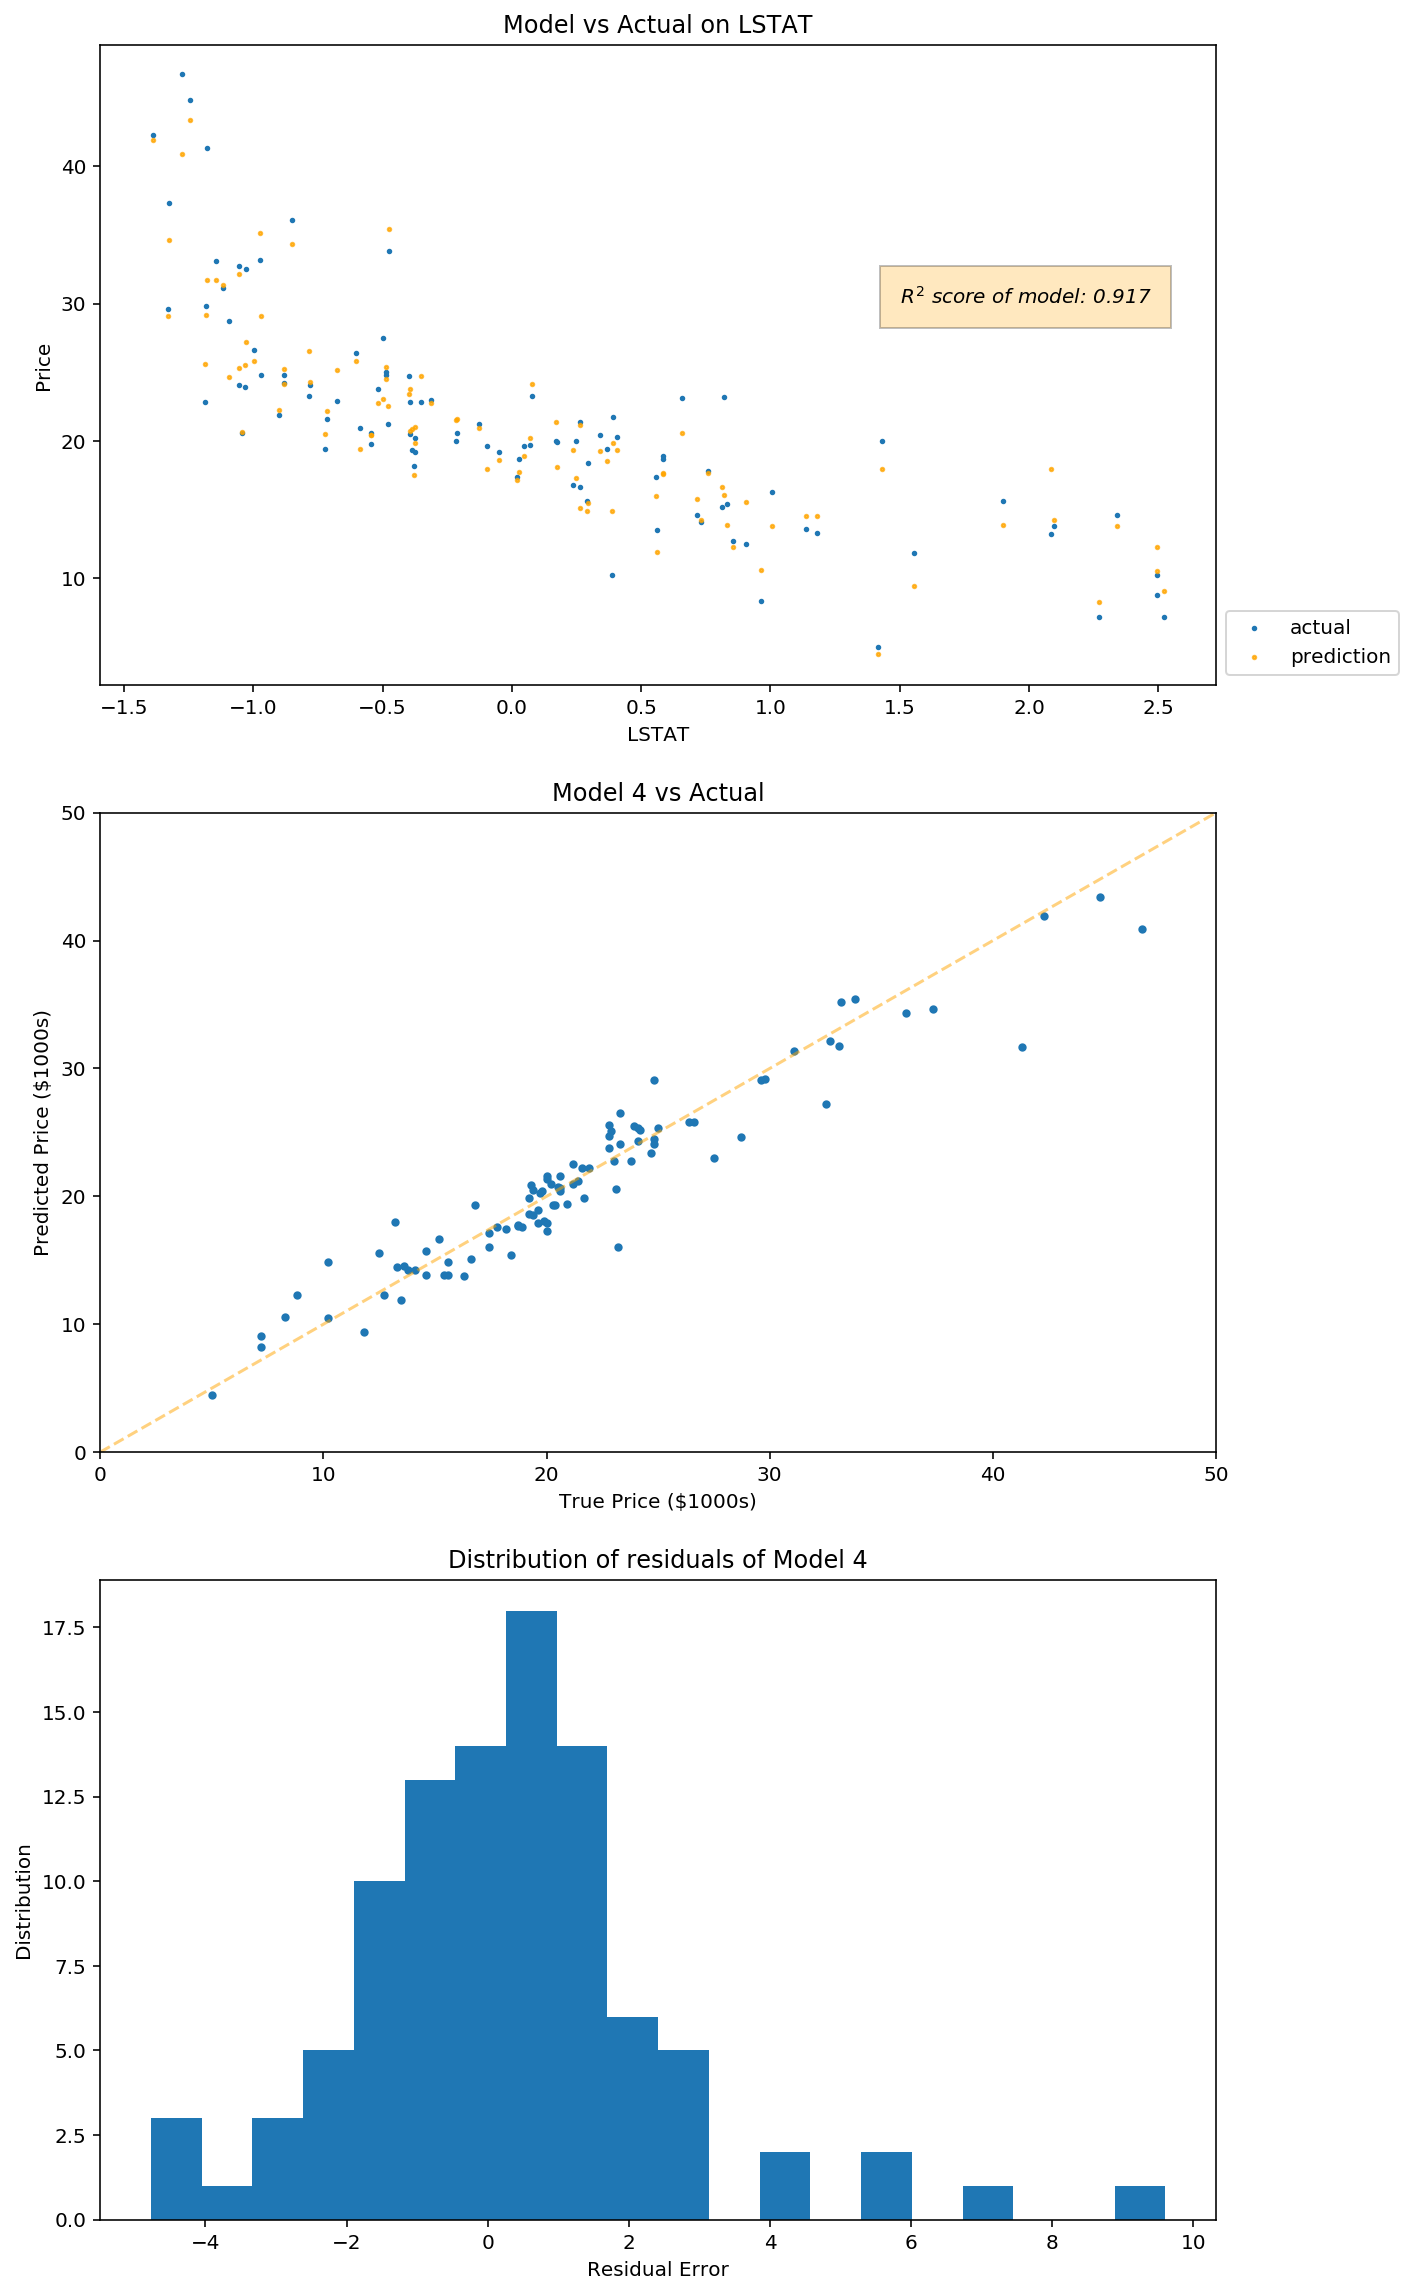

In [33]:
figure, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 20)) 

ax[0].scatter(plot["LSTAT"],plot["actual"], s = 3, label ='actual');
ax[0].scatter(plot["LSTAT"], plot["pred"], s=3, alpha = .75, c='orange', label ='prediction');
ax[0].set_xlabel("LSTAT");
ax[0].set_ylabel('Price');
ax[0].set_title("Model vs Actual on LSTAT");
ax[0].text(1.5, 30, '${}${}{}'.format('R^2'," score of model: ",str(round(r2_score(y_test,pred),3))), style='italic',
         bbox={'facecolor': 'orange', 'alpha': 0.25, 'pad': 10});

ax[0].legend(loc='lower left', bbox_to_anchor=(1, 0));


ax[1].plot([0, 50], [0, 50], color = "orange", alpha = .5, ls='--')
ax[1].scatter(y_test, pred, s = 10);
ax[1].set_ylim((0,50))
ax[1].set_xlim((0,50))
ax[1].set_xlabel('True Price ($1000s)');
ax[1].set_ylabel('Predicted Price ($1000s)');
ax[1].set_title("Model 4 vs Actual");

ax[2].hist(residuals, bins = 20);
ax[2].set_xlabel('Residual Error');
ax[2].set_ylabel('Distribution');
ax[2].set_title("Distribution of residuals of Model 4");

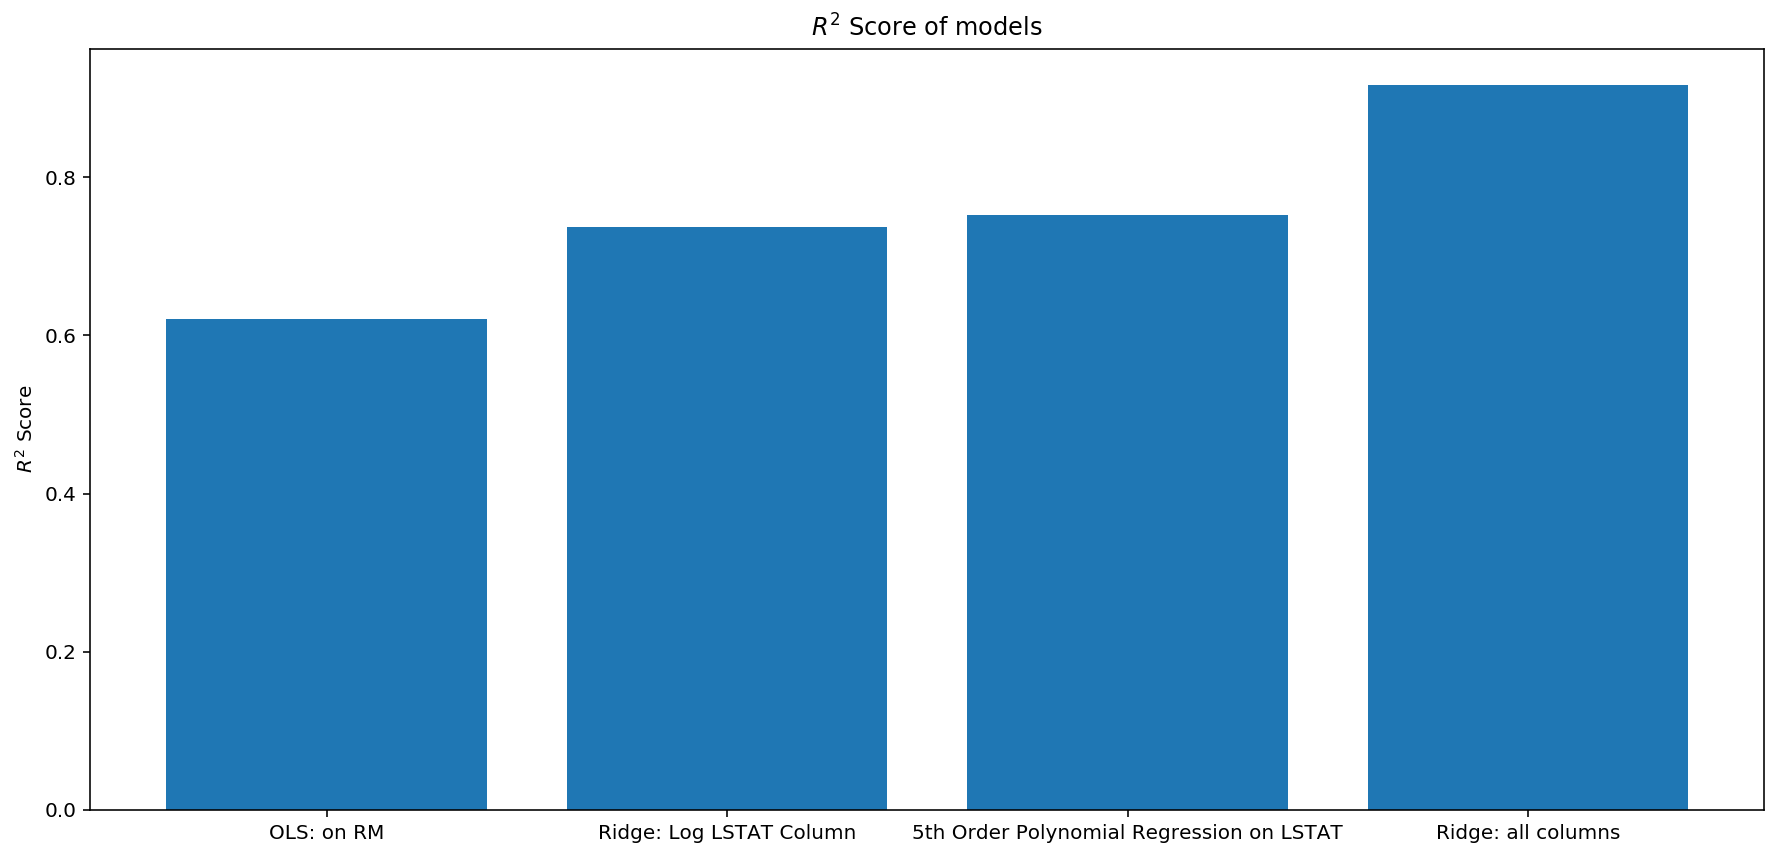

In [94]:
D = {"OLS: on RM":model_1, 
 "Ridge: Log LSTAT Column":model_2,
 "5th Order Polynomial Regression on LSTAT":model_3,
 "Ridge: all columns":model_4}

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7)) 

plt.bar(range(len(D)), D.values(), align='center');
plt.xticks(range(len(D)), list(D.keys()));
plt.ylabel('${}$ Score'.format("R^2"));
plt.title('${}$ Score of models'.format("R^2"));